In [1]:
#Cue: https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
data = pd.read_csv('conventional_data.csv')
y_ = data['consensus_act']

X_all = data.drop(['consensus_act', 'PUBCHEM_SID', 'gmin'], axis = 1)
X_all.replace([np.inf, -np.inf], np.nan, inplace=True) #replace all infinite values with NaN

X_all = X_all.dropna(axis=1, how='all') #Drop any column that has all NaN
X_all.fillna(value = X_all.mean(axis=0), inplace=True) #Impute mean in place on NaN

#X_all.loc[:, X_all.isnull().any()] See which column still had NaN after prepocessing. gmin was removed
print('Shape of X_all before removing low variance features:', X_all.shape)

#0.16 =(.8 * (1 - .8)) that is the threshold for features that are constant in 80% of the instances
feat = VarianceThreshold(threshold=0.16)
feat.fit_transform(X_all)
X_all = X_all[X_all.columns[feat.get_support(indices=True)]] #retain column names
X_spotcheck = StandardScaler().fit_transform(X_all)


/ihome/gidakwo/anaconda3/envs/ml_env/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape of X_all before removing low variance features: (10251, 17966)


In [3]:
print('Shape of X after removing low variance features:', X_spotcheck.shape)

Shape of X after removing low variance features: (10251, 2491)


In [4]:
models = []
#models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', LinearSVC()))
models.append(('DNN', MLPClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'f1_macro'
for name, model in models:
    kfold = StratifiedKFold(n_splits=5)
    cv_results = cross_val_score(model, X_spotcheck, y_, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print(cv_results)

KNN: 0.515874 (0.013611)
[ 0.52677136  0.49303363  0.52486953  0.5273646   0.50733192]
RF: 0.548463 (0.033769)
[ 0.58018966  0.58051313  0.54966596  0.54386104  0.4880856 ]
CART: 0.474942 (0.029696)
[ 0.51363201  0.48431834  0.46051232  0.49014159  0.42610509]
NB: 0.309541 (0.047032)
[ 0.34221247  0.36500027  0.33388126  0.25316888  0.25344417]
SVM: 0.508398 (0.038199)
[ 0.53001052  0.55798765  0.52556323  0.47344707  0.45498054]
DNN: 0.535589 (0.046715)
[ 0.56071184  0.59015011  0.50329791  0.46120883  0.562577  ]


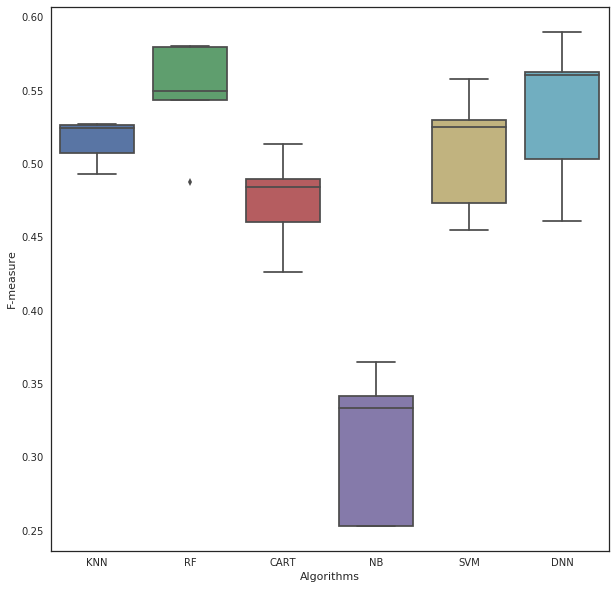

In [5]:
plot_data = pd.DataFrame(np.transpose(results), columns=names)

import seaborn as sns

sns.set(rc={'figure.figsize':(10,10)}, style='white')
sns.boxplot(data=plot_data).set(
    xlabel='Algorithms', 
    ylabel='F-measure'
)

In [6]:
df_results = pd.DataFrame(results)
df_results.to_csv("spotcheck_results.csv")